In [1]:
import sys
import stmpy
import numpy as np
import cancelv3 as cancel
from decimal import *
import matplotlib.pyplot as plt
from sklearn.externals import joblib

import scipy.fftpack as fftp
import os

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
%pylab inline

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

from scipy import signal

Populating the interactive namespace from numpy and matplotlib


C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
# A function that returns array with the n-th degree polynomial background removed. 
def fit_cancel(array, n=1):
    t=linspace(0,len(array),len(array))
    fit = polyfit(t,array,n)
    corrective = fit[n]*ones(shape(t))
    for j in arange(n):
        corrective += fit[j]*(t**(n-j))
    return array - corrective

# Same implementation as in cancelv3.py. but with any given transfer function/frequencies.
# Useful when storing a transfer function as a 2D array of complex numbers/frequencies.
def create_drive(zdata, dt2, tf, freqs):
    fbottom2 = np.fft.fft(zdata)
    freq2 = np.fft.fftfreq(len(zdata),dt2)
    freq2[freq2 > freqs[np.argmax(freqs)]] = freqs[np.argmax(freqs)]
    freq2[freq2 < freqs[np.argmin(freqs)]] = freqs[np.argmin(freqs)]
    driver = np.fft.ifft(tf(freq2)*fbottom2)
    return driver

# A function to remove tip-change jumps in the data. Array is the input data and tol is the
# tolerance level between tip changes (i.e. 3E-12 for cancelling 3pm jumps in data).
def cancel_skips(array, tol):
    data = array[15:]-array[:-15]
    markers = where(abs(data)>=tol)*sign(data)[where(abs(data)>=tol)]
    result = array[0:abs(int(markers[0][0]))]
    counter=markers[0][0]
    gap = 0
    for idx in markers[0]:
        if (counter*idx) < 1:
            result = concatenate((result,array[abs(int(counter)):abs(int(idx))]-gap))
            counter = idx
            gap = 0
        else:
            if markers[0][0] > 0: gap = max(gap,data[abs(int(idx))])
            else: gap = min(gap,data[abs(int(idx))])
    if shape(array) is not shape(result):
        result = concatenate((result,array[abs(int(counter)):]-gap))
    return result

# Creating a transfer function

In [4]:
# load data
file_name = "trx_2-"
folder_name = "Albert_Data/2019-02-26/"

# trx_2.npy is a numpy array compiled from a calibration measurement
dat=load(folder_name+"trx_2.npy")
geo=dat[:,0]
z=dat[:,1]

In [5]:
# calibrate transfer function. See cancelv3.py for more info about cancel.Cancel()
scan_freq=10000
nc = cancel.Cancel(geo-mean(geo),z,(1/scan_freq),p=[200000,125000,5])
folder_name = "Albert_Data/2019-02-26/"
filename = 'trx_2'
# saves only the transfer function frequencies and corresponding complex numbers
joblib.dump([nc.transf, nc.freqs], folder_name+filename)

KeyboardInterrupt: 

# Ambient Topographic Scan Cancellation

In [5]:
# fixed values in this case, but active values in Python script
dd = 28
mm = 1
yyyy = 2019

date_string = "{0:0=4d}".format(yyyy) + "-" + "{0:0=2d}".format(mm) + "-" + "{0:0=2d}".format(dd)
folder_name = "Data/"+date_string+"/"
file_name = "-geophone-scan"

In [6]:
[transf, freqs] = joblib.load('Data/2019-01-26/transfer-fxn3') # previously calibrated transfer function

i = 1
temp_data = np.loadtxt(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=137)[:,(1,4,5,6)]
# os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat") # removes data files after loading
while True:
    i += 1
    try:
        temp_data = np.concatenate((temp_data, np.loadtxt(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=137)[:,(1,4,5,6)]))
        # os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat") # removes data files after loading
    except:
        break
        
a=1
# Throw out data at the start and end, where the scan was not in progress
# temp_data=temp_data[np.where(temp_data[:-1,a] != temp_data[1:,a])[0][0]:np.where(temp_data[:-1,a] != temp_data[1:,a])[0][-1]]
temp_data = temp_data[2494500:3939500]


In [7]:
# Extracting X,Y,Z,G out of the data
# Account for the angle at which the scan is taken

ang=107.4*pi/180

scan_freq = 10000 # S/s

geo = create_drive(temp_data[:,0], 1/scan_freq, transf,freqs)
x = math.cos(ang)*temp_data[:,1]-math.sin(ang)*temp_data[:,2]
y = math.sin(ang)*temp_data[:,1]+math.cos(ang)*temp_data[:,2]
z = temp_data[:,3]
%reset_selective -f temp_data # Clear some memory

In [8]:
# scan parameters
x_min = Decimal(x.min())
x_max = Decimal(x.max())
y_min = Decimal(y.min())
y_max = Decimal(y.max())
img_w = 256 # px/line
img_h = 256
img_wm = 20e-9 # m/line
img_hm = 20e-9

In [9]:
xrange = x_max-x_min
y_range = y_max-y_min

pixel_dx = xrange / (img_w)
pixel_dy = xrange / (img_h)

# used to differentiate between forward and back scan values
dx = np.gradient(x)

# empty arrays for output
fr_scan = np.empty((img_w,img_h), dtype=object)
bk_scan = np.empty((img_w,img_h), dtype=object)

cn_fr_scan = np.empty((img_w,img_h), dtype=object)
cn_bk_scan = np.empty((img_w,img_h), dtype=object)

for idx, el in enumerate(z):
    ix = int((Decimal(x[idx]) - x_min) // pixel_dx) # finding the appropriate pixel index
    iy = int((Decimal(y[idx]) - y_min) // pixel_dy) # finding the appropriate pixel index
    if ix >= img_w: ix = img_w-1 # if out of bounds, place in largest pixel index
    if iy >= img_h: iy = img_h-1 # if out of bounds, place in largest pixel index
#   Forward scan values
    if dx[idx] > 0:
        if fr_scan[ix,iy] == None: fr_scan[ix,iy] = [el]
        else: fr_scan[ix,iy].append(el)
        if cn_fr_scan[ix,iy] == None: cn_fr_scan[ix,iy] = [geo[idx]]
        else: cn_fr_scan[ix,iy].append(geo[idx])
#   Backward scan values
    else:
        if bk_scan[ix,iy] == None: bk_scan[ix,iy] = [el]
        else: bk_scan[ix,iy].append(el)
        if cn_bk_scan[ix,iy] == None: cn_bk_scan[ix,iy] = [geo[idx]]
        else: cn_bk_scan[ix,iy].append(geo[idx])

In [10]:
raw=np.zeros((img_w,img_h))
output=np.zeros((img_w,img_h))

# Forward scan values (average, or take mean value of neighbors if None)

for yi, row in enumerate(fr_scan):
    for xi, l in enumerate(row):
        if l != None: raw[-xi,yi] = np.mean(np.array(l))
        else: raw[-xi, yi] = np.mean(z)
    
for yi, row in enumerate(cn_fr_scan):
    for xi, l in enumerate(row):
        if l != None: output[-xi,yi] = raw[-xi, yi]-np.mean(np.array(l))
        else: output[-xi, yi] = np.mean(z)

# Backward scan values (average, or take mean value of neighbors if None)

# output_rev=np.zeros((img_w,img_h))
# processed_rev=np.zeros((img_w,img_h))

# for yi, row in enumerate(bk_scan):
#     for xi, l in enumerate(row):
#         if l != None: output_rev[-xi,yi] = np.mean(np.array(l))
#         else: output_rev[-xi, yi] = np.mean(z)

C:\Users\Albert Chien\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


C:\Users\Albert Chien\AppData\Roaming\Python\Python36\site-packages\matplotlib\font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


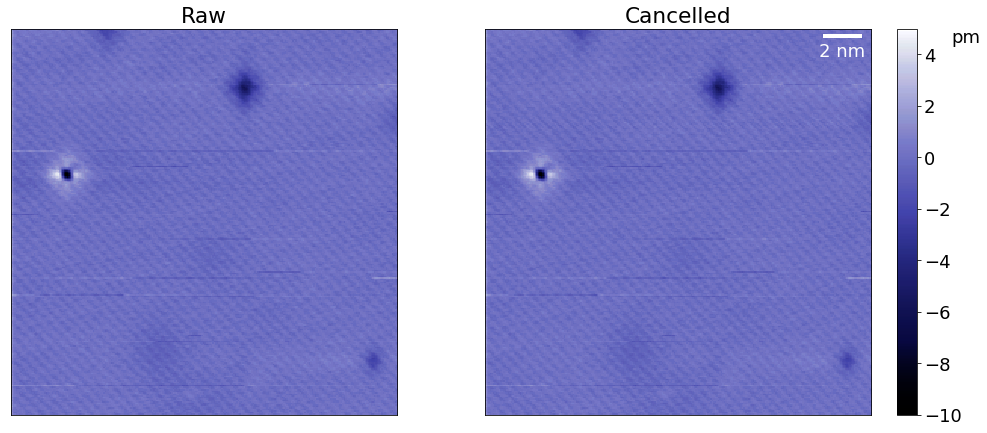

In [11]:
from matplotlib_scalebar.scalebar import ScaleBar
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

fig,ax=subplots(1,2,figsize=(15,6))
im1=ax[0].imshow(stmpy.tools.lineSubtract(raw*1e12),rasterized=True,cmap=stmpy.cm.blue2,clim=(-10,5))
im2=ax[1].imshow(stmpy.tools.lineSubtract(output*1e12), rasterized=True,cmap=stmpy.cm.blue2,clim=(-10,5))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
tight_layout()

cb=fig.colorbar(im2)
l=cb.set_label('pm', rotation='horizontal',y=1)

ax[0].set_title('Raw')
ax[1].set_title('Cancelled')

scalebar = ScaleBar(img_wm/img_w,color='w',frameon=False,font_properties=font)
plt.gca().add_artist(scalebar)

## Finding Pixel Value Errors between Python and Nanonis

In [12]:
read = stmpy.load("Data/2019-01-28/2019-01-28_CeSb_00004.sxm")
img = read.channels['Z_Fwd']
img_b = read.channels['Z_Bkd']

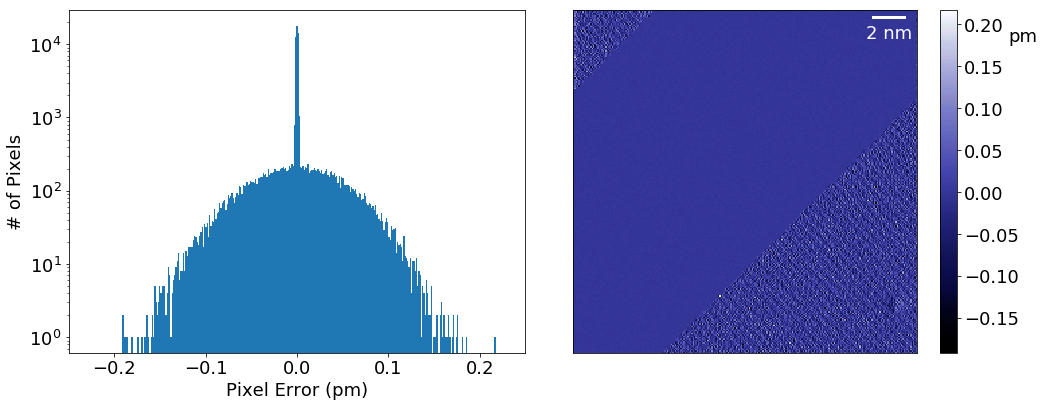

In [13]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

fig,ax=subplots(1,2,figsize=(15,6))
# there is an offset between the Python and Nanonis images.
# I couldn't figure out why this offset existed.
xoffset=1 
im1=ax[0].hist(reshape(raw[xoffset:,:]-img[:-xoffset,:],-1)*1e12,bins=300,log=True)
im2=ax[1].imshow(raw[xoffset:,:]*1e12-img[:-xoffset,:]*1e12, rasterized=True,cmap=stmpy.cm.blue2)


ax[0].set_xlim(-0.25,0.25)
# xlim(-1e-2,1e-2)
ax[0].set_ylabel('# of Pixels')
ax[0].set_xlabel('Pixel Error (pm)')
cb=fig.colorbar(im2)
ax[1].set_xticks([])
ax[1].set_yticks([])

l=cb.set_label('pm', rotation='horizontal',y=0.95)

scalebar = ScaleBar(img_wm/img_w,color='w',frameon=False,font_properties=font)
plt.gca().add_artist(scalebar)

tight_layout()

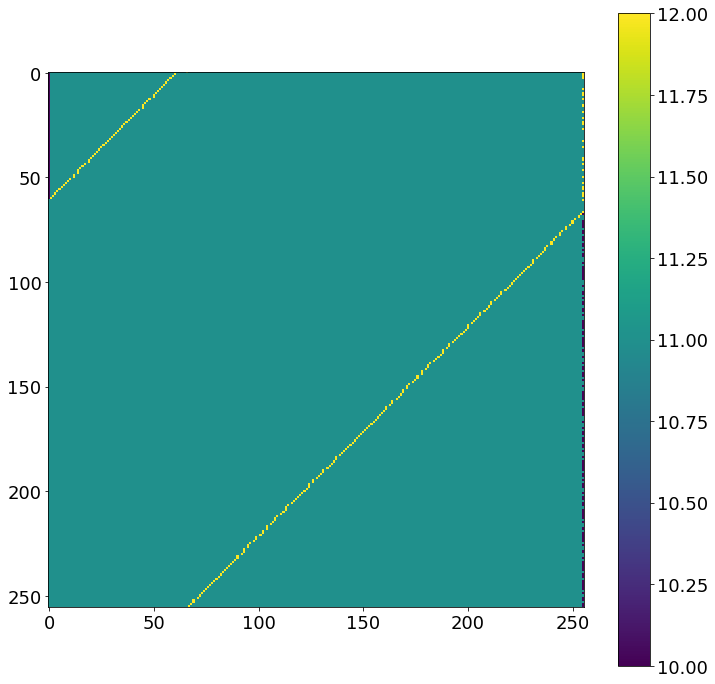

In [14]:
# A promising direction to solve the pixel value errors: some binning issue in my code

dat_size=np.zeros((img_w,img_h))

for yi, row in enumerate(fr_scan):
    for xi, l in enumerate(row):
        if l != None: dat_size[-xi,yi] = size(np.array(l))
        else: dat_size[-xi, yi] = 0
            
figsize(12,12)
imshow(dat_size)
colorbar()

# Noisy Topographic Scan Cancellation

In [25]:
# Loading transfer function and data

[transf, freqs] = joblib.load('Albert_Data/2019-02-26/trx_2') # previously calibrated transfer function

folder_name = "Albert_Data/2019-02-26/"
file_name='topo_2-'

# Load as many files as possible under the file_name
i = 1
temp_data = np.loadtxt(folder_name+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=6)
# os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
while True:
    i += 1
    try:
        temp_data = np.concatenate((temp_data, np.loadtxt(folder_name+file_name+"%(number)03d"%{"number": i}+".dat", skiprows=6)))
        # os.remove(folder_name+date_string+file_name+"%(number)03d"%{"number": i}+".dat")
    except:
        break
        

a=1
# Throw out data at the start and end, where the scan was not in progress
temp_data=temp_data[np.where(temp_data[:-1,a] != temp_data[1:,a])[0][0]:np.where(temp_data[:-1,a] != temp_data[1:,a])[0][-1]]

# Extracting X,Y,Z,G out of the data
# Account for the angle at which the scan is taken
ang=109.4*pi/180
scan_freq=10000
geo = create_drive(temp_data[:,0], 1/scan_freq, transf,freqs)
x = math.cos(ang)*temp_data[:,a]-math.sin(ang)*temp_data[:,a+1]
y = math.sin(ang)*temp_data[:,a]+math.cos(ang)*temp_data[:,a+1]
z = temp_data[:,a+2]
%reset_selective -f temp_data # Clear some memory

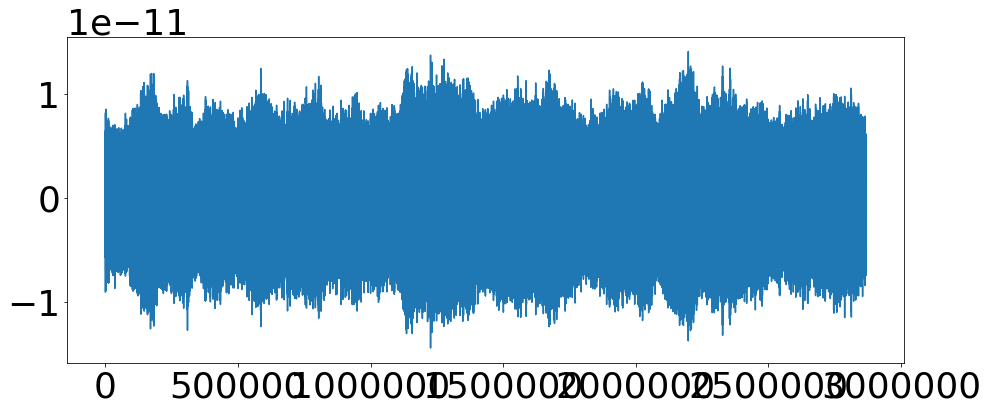

In [26]:
plot(geo)
# plot(freqs,abs(transf(freqs)))
# xlim(0,100)

0.0034850199900746627


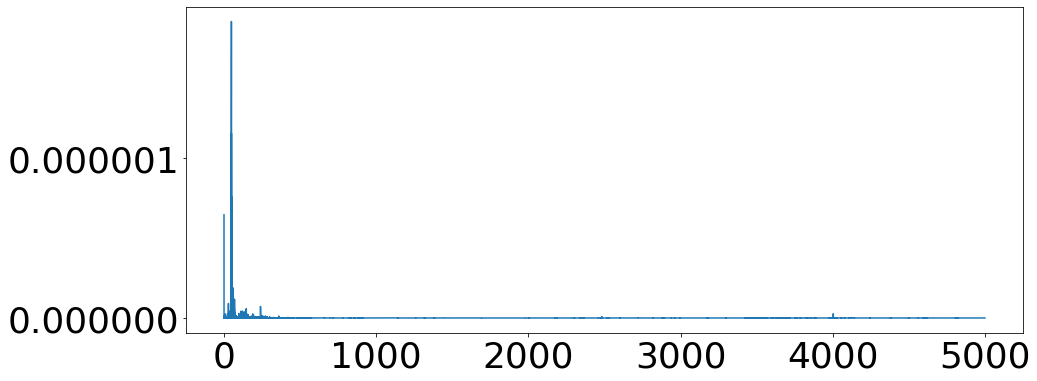

In [27]:
figsize(15,6)
tip_fft = fft.fft(z)
geo_fft = fft.fft(geo)
freqs = fft.fftfreq(len(geo),1/10000)
print(freqs[1])
plot(freqs[:int(len(geo_fft)/2)],absolute(geo_fft[:int(len(geo_fft)/2)]))
# plot(freqs[int(48.75/freqs[1])],absolute(geo_fft[int(48.75/freqs[1])]),'.')
# xlim(45,200)
# xlim(97,98)
# ylim(0,0.000002)

In [28]:
noise = 48.75
harmonic = [int(noise/freqs[1]),int(noise*2/freqs[1]),int(noise*3/freqs[1]),int(noise*4/freqs[1]),int(noise*5/freqs[1])]

(0, 1e-06)

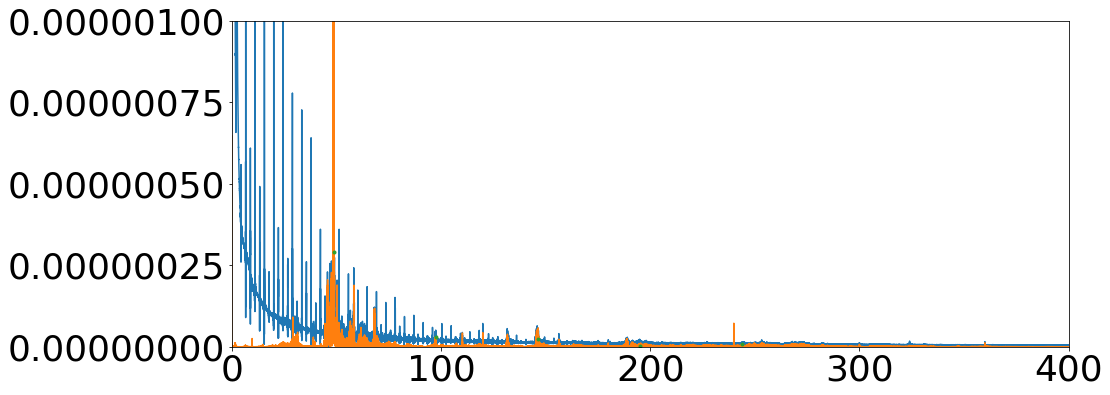

In [29]:

plot(freqs[:int(len(tip_fft)/2)],absolute(tip_fft[:int(len(tip_fft)/2)]))
plot(freqs[:int(len(geo_fft)/2)],absolute(geo_fft[:int(len(geo_fft)/2)]))
# xlim(48,50)
# ylim(0,0.000002)
# xlim(95,100)
# ylim(0,0.00000005)
# xlim(143,149)
# ylim(0,0.0000001)
# xlim(110,220)
# ylim(0,0.0000001)
plot(freqs[harmonic],absolute(tip_fft[harmonic]),'.')
xlim(0,400)
ylim(0,0.000001)
#2.25  #6.695  #11.15775  #15.625
#4.45  #8.915  #13.4 

In [30]:
# scan parameters
x_min = Decimal(x.min())
x_max = Decimal(x.max())
y_min = Decimal(y.min())
y_max = Decimal(y.max())
img_w = 640 # px/line
img_h = 640

# not necessary, but used for plotting
img_wm = 10e-9 # m/line
img_hm = 10e-9

In [31]:
xrange = x_max-x_min
y_range = y_max-y_min

pixel_dx = xrange / (img_w)
pixel_dy = xrange / (img_h)

# used to differentiate between forward and back scan values
dx = np.gradient(x)

# empty arrays for output
fr_scan = np.empty((img_w,img_h), dtype=object)
bk_scan = np.empty((img_w,img_h), dtype=object)

cn_fr_scan = np.empty((img_w,img_h), dtype=object)
cn_bk_scan = np.empty((img_w,img_h), dtype=object)

# 
for idx, el in enumerate(z):
    ix = int((Decimal(x[idx]) - x_min) // pixel_dx)
    iy = int((Decimal(y[idx]) - y_min) // pixel_dy)
    if ix >= img_w: ix = img_w-1
    if iy >= img_h: iy = img_h-1
    if dx[idx] > 0:
        if fr_scan[ix,iy] == None: fr_scan[ix,iy] = [el]
        else: fr_scan[ix,iy].append(el)
        if cn_fr_scan[ix,iy] == None: cn_fr_scan[ix,iy] = [geo[idx]]
        else: cn_fr_scan[ix,iy].append(geo[idx])
    else:
        if bk_scan[ix,iy] == None: bk_scan[ix,iy] = [el]
        else: bk_scan[ix,iy].append(el)
        if cn_bk_scan[ix,iy] == None: cn_bk_scan[ix,iy] = [geo[idx]]
        else: cn_bk_scan[ix,iy].append(geo[idx])

In [32]:
raw=np.zeros((img_w,img_h))
output=np.zeros((img_w,img_h))

filler=[]

for yi, row in enumerate(fr_scan):
    for xi, l in enumerate(row):
        if l != None: raw[-xi,yi] = np.mean(np.array(l))
        else:
            print((xi,yi))
            filler.append((-int(xi),int(yi)))
        
for xi,yi in filler:
    print(np.mean((raw[xi-1,yi],raw[xi+1,yi],raw[xi,yi-1],raw[xi,yi+1])))
    raw[xi,yi] = np.mean((raw[xi-1,yi],raw[xi+1,yi],raw[xi,yi-1],raw[xi,yi+1]))
            
for yi, row in enumerate(cn_fr_scan):
    for xi, l in enumerate(row):
        if l != None: output[-xi,yi] = raw[-xi, yi]-np.mean(np.array(l))
        else: output[-xi, yi] = raw[-xi,yi]

C:\Users\jgoet\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: ComplexWarning: Casting complex values to real discards the imaginary part


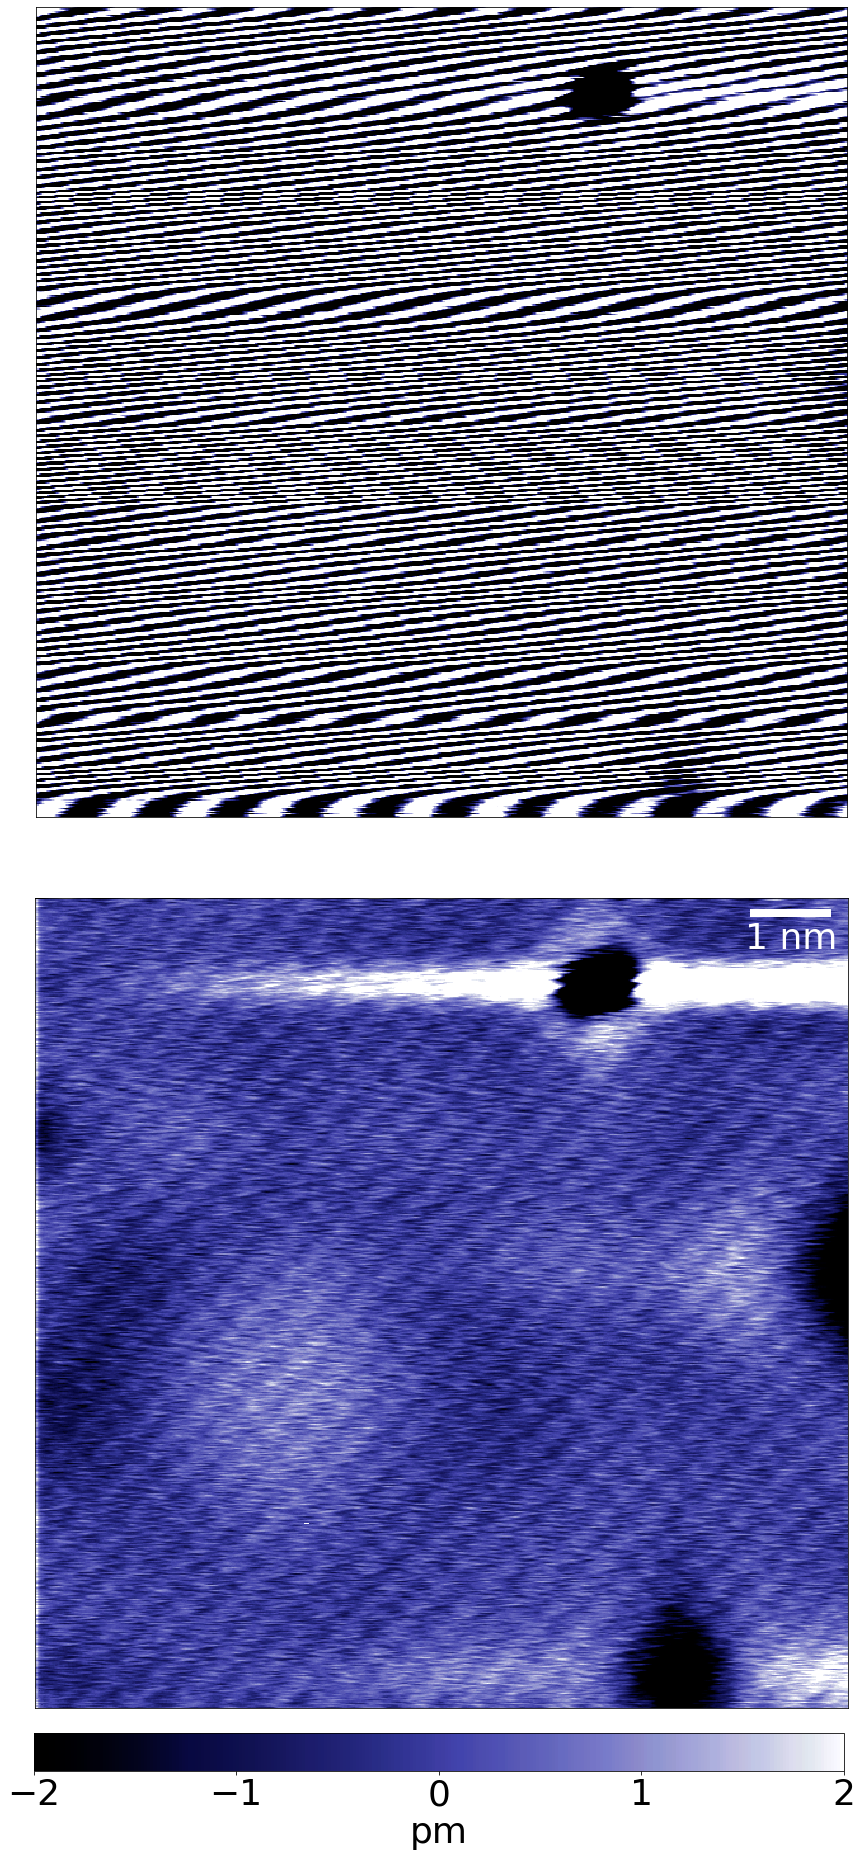

In [33]:
from matplotlib_scalebar.scalebar import ScaleBar

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 36}
matplotlib.rc('font', **font)

fig,ax=subplots(2,1,figsize=(15,35))
im1=ax[0].imshow(stmpy.tools.lineSubtract(raw[1:,:]*1e12),rasterized=True,cmap=stmpy.cm.blue2,vmin=-2,vmax=2)
im2=ax[1].imshow(stmpy.tools.lineSubtract(output[:-2,:]*1e12), rasterized=True,cmap=stmpy.cm.blue2,clim=(-2,2))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

scalebar = ScaleBar(img_wm/img_w,color='w',frameon=False,font_properties=font)
plt.gca().add_artist(scalebar)

fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.135, 0.1,0.75, 0.015])
# [left, bottom, width, height]
cb=fig.colorbar(im2, cax=cbar_ax,orientation='horizontal')
l=cb.set_label('pm', rotation='horizontal')
plt.subplots_adjust(wspace=0, hspace=0.1)

# Testing Different Parameters of the Windowing Function

In [20]:
# Defining the holdout data segments
hold_out = 10*arange(1,101)
results = zeros((10,100))

In [21]:
folder_name = 'Data/2019-02-21/'
file_name = 'fast-transfer-function-'

# Testing various values for the windowing parameter (segment length in this case)
for k in arange(0,10):
    i=1
    
#   Calibrating a transfer function
    dat=loadtxt(folder_name+file_name+str(i).zfill(3)+'.dat',skiprows=6)
    for i in arange(2,101):
        if i not in hold_out:
            dat=concatenate((dat,loadtxt(folder_name+file_name+str(i).zfill(3)+'.dat',skiprows=6)))
    nc=cancel.Cancel(dat[:,0]-mean(dat[:,0]),fit_cancel(dat[:,1]),1/10000,p=[200000,50000,5])

    for j in arange(1,k+1):
        print(j) # indicator for tracking progress
        i=1+j*100
        dat=loadtxt(folder_name+file_name+str(i).zfill(3)+'.dat',skiprows=6)
        for i in arange(2+j*100,101+j*100):
            if i not in hold_out and i != 1000:
                dat=concatenate((dat,loadtxt(folder_name+file_name+str(i).zfill(3)+'.dat',skiprows=6)))
        nc.update_transf(dat[:,0]-mean(dat[:,0]),fit_cancel(dat[:,1]),1/10000,p=[200000,50000,5])
    
#   Evaluate the % RMS reduction of transfer function
    N=0
    std1=0
    std2=0
    for i in hold_out[:-1]:
        dat=loadtxt(folder_name+file_name+str(i).zfill(3)+'.dat',skiprows=6)
        results[k,N]=std(fit_cancel(dat[:,1]-nc.create_drive(dat[:,0]-mean(dat[:,0]))))/std(fit_cancel(dat[:,1]))
        N+=1

1
1
2
1
2
3
1
2
3
4
1
2
3
4
5
1
2
3
4
5
6
1
2
3
4
5
6
7
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
9


Text(0, 0.5, ' Reduction in RMS Noise (%)')

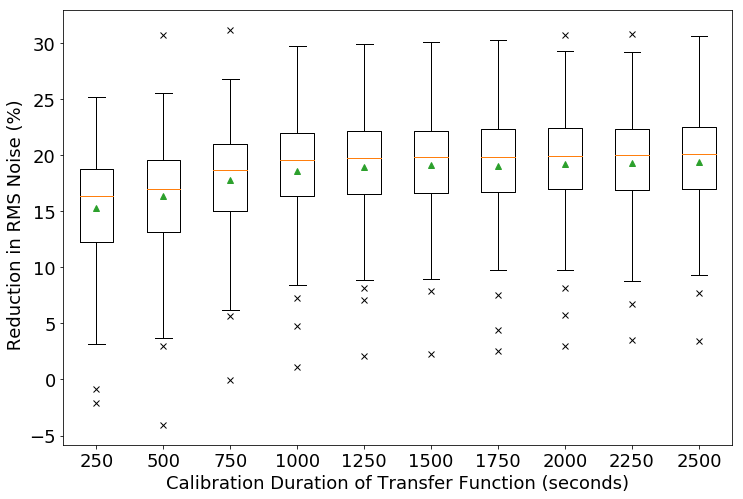

In [22]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}
matplotlib.rc('font', **font)

fig, ax = subplots(figsize=(12,8))
boxplot(transpose(1-results[:,:99])*100, 0, 'x',showmeans=True)
ax.set_xticklabels(np.arange(250, 2501, 250))
xlabel('Calibration Duration of Transfer Function (seconds)')
ylabel(' Reduction in RMS Noise (%)')